# Problem statement
Monitoring data (BEMS & DEMS):
    1. Energy
    2. Temperature
    3. Flow
    4. more ...

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import random
from sklearn.preprocessing import OrdinalEncoder
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from datetime import datetime
from holidays_es import Province
# import pywt

# Data 
## Data loading

In [3]:
df1 = pd.read_csv('../VEOLIA/Data/UC4-2020-11to12.csv', delimiter=';', header=None, index_col=None)
df2 = pd.read_csv('../VEOLIA/Data/UC4-2021-01to03.csv', delimiter=';', header=None, index_col=None)
df3 = pd.read_csv('../VEOLIA/Data/UC4-2021-04to06.csv', delimiter=';', header=None, index_col=None)
df = pd.concat([df1, df2, df3])
df.columns = ['location', 'meter_id', 'meter_name', 'time', 'value']
df1.columns = ['location', 'meter_id', 'meter_name', 'time', 'value']
df2.columns = ['location', 'meter_id', 'meter_name', 'time', 'value']
df3.columns = ['location', 'meter_id', 'meter_name', 'time', 'value']

variables = pd.read_csv('../VEOLIA/Data/Pilot2_Variables_UC4.csv', delimiter=';')
id_to_name = dict(zip(variables['ID'], variables['Variable']))
name_to_id = dict(zip(variables['Variable'], variables['ID']))

print('Dataset structure')
df.head()

Dataset structure


,location,meter_id,meter_name,time,value
0,EDEN1C - M203299 - CORTES DE FUENSALDAÑA,78562,CONTADOR GAS CALDERA 1 (15 minuto),2020-11-01 00:00:00.000,"1623,90"
1,EDEN1C - M203299 - CORTES DE FUENSALDAÑA,78562,CONTADOR GAS CALDERA 1 (15 minuto),2020-11-01 00:15:00.000,"1623,90"
2,EDEN1C - M203299 - CORTES DE FUENSALDAÑA,78562,CONTADOR GAS CALDERA 1 (15 minuto),2020-11-01 00:30:00.000,"1637,00"
3,EDEN1C - M203299 - CORTES DE FUENSALDAÑA,78562,CONTADOR GAS CALDERA 1 (15 minuto),2020-11-01 00:45:00.000,"1649,40"
4,EDEN1C - M203299 - CORTES DE FUENSALDAÑA,78562,CONTADOR GAS CALDERA 1 (15 minuto),2020-11-01 01:00:00.000,"1661,30"


Unfortunately we can see that not all dataframes contain all variables:

In [4]:
print('7 Variables for 11-12/2020:\n', df1['meter_name'].unique())
print('7 Variables for 01-03/2021\n', df2['meter_name'].unique())
print('Variables for 04-06/2020\n', df3['meter_name'].unique())

Variables for 11-12/2020:
 ['CONTADOR GAS CALDERA 1 (15 minuto)' 'CONTADOR GAS CALDERA 2 (15 minuto)'
 'Energía Caldera 1 (15 minuto)' 'Energía Caldera 2 (15 minuto)'
 'Energía Primario ACS (15 minuto)' 'Energía Consumo ACS (15 minuto)'
 'Energia Activa Total (15 minuto)']
Variables for 01-03/2021
 ['CONTADOR GAS CALDERA 1 (15 minuto)' 'CONTADOR GAS CALDERA 2 (15 minuto)'
 'Energía Caldera 1 (15 minuto)' 'Energía Caldera 2 (15 minuto)'
 'Energía Primario ACS (15 minuto)' 'Energía Consumo ACS (15 minuto)'
 'Energia Activa Total (15 minuto)']
Variables for 04-06/2020
 ['TEMPERATURA EXTERIOR (15 minuto)' 'CONTADOR GAS CALDERA 1 (15 minuto)'
 'CONTADOR GAS CALDERA 2 (15 minuto)' 'Energía Caldera 1 (15 minuto)'
 'Caudal Caldera 1 (15 minuto)'
 'TEMPERATURA COLECTOR IMPULSION (15 minuto)'
 'Volumen Caldera 1 (15 minuto)' 'Potencia Caldera 1 (15 minuto)'
 'Temper Impulsion Caldera 1 (15 minuto)'
 'Temper Retorno Caldera 1 (15 minuto)' 'Energía Caldera 2 (15 minuto)'
 'Caudal Caldera 2 (15 min

This is the crucial date where the extra variables are added to the dataset. New variables are added the 14th of May 2021 at 09:15:00am. From then on the dataset is full.

In [50]:
print("Number of variables before 14/5/2021 09:15:00:", df[df.datetime < datetime(2021, 5, 14, 9, 15, 0)]['meter_id'].unique().shape[0])
print("Number of variables on 14/5/2021 after 09:15:00:", df[(df.datetime >= datetime(2021, 5, 14, 9, 15, 0)) & (df.datetime < datetime(2021, 5, 14, 9, 30, 0))]['meter_id'].unique().shape[0])
print("Number of variables on 15/5/2021:", df[df.datetime == datetime(2021, 5, 15)]['meter_id'].unique().shape[0])
print("Number of variables after 15/5/2021:", df[df.datetime > datetime(2021, 5, 15)]['meter_id'].unique().shape[0])
a1 = df[df.datetime < datetime(2021, 5, 14)]
a = df[(df.datetime <= datetime(2021, 5, 14, 23, 59, 59)) & (df.datetime >= datetime(2021, 5, 14, 0, 0, 0))]

Number of variables before 14/5/2021 09:15:00: 7
Number of variables on 14/5/2021 after 09:15:00: 36
Number of variables on 15/5/2021: 36
Number of variables after 15/5/2021: 36


The new variables added are the following 29:

In [80]:
big = set(df3['meter_name'].unique())
small =  set(df1['meter_name'].unique())
big - small

{'Caudal Caldera 1 (15 minuto)',
 'Caudal Caldera 2 (15 minuto)',
 'Caudal Consumo ACS (15 minuto)',
 'Caudal Primario ACS (15 minuto)',
 'DEMANDA ACS (15 minuto)',
 'DEMANDA CALEFACCIÓN (15 minuto)',
 'DEMANDA QUEMADORES (15 minuto)',
 'Potencia Caldera 1 (15 minuto)',
 'Potencia Caldera 2 (15 minuto)',
 'Potencia Consumo ACS (15 minuto)',
 'Potencia Primario ACS (15 minuto)',
 'TEMPERATUR COLECTOR RETORNO (15 minuto)',
 'TEMPERATURA COLECTOR IMPULSION (15 minuto)',
 'TEMPERATURA DEPOSITO 1 ACS (15 minuto)',
 'TEMPERATURA DEPOSITO 2 ACS (15 minuto)',
 'TEMPERATURA EXTERIOR (15 minuto)',
 'TEMPERATURA IMPULSION CALEFACC (15 minuto)',
 'Temper Impulsion Caldera 1 (15 minuto)',
 'Temper Impulsion Caldera 2 (15 minuto)',
 'Temper Impulsion Consumo ACS (15 minuto)',
 'Temper Impulsion Primario ACS (15 minuto)',
 'Temper Retorno Caldera 1 (15 minuto)',
 'Temper Retorno Caldera 2 (15 minuto)',
 'Temper Retorno Consumo ACS (15 minuto)',
 'Temper Retorno Primario ACS (15 minuto)',
 'Volumen Ca

array(['TEMPERATURA EXTERIOR (15 minuto)',
       'CONTADOR GAS CALDERA 1 (15 minuto)',
       'CONTADOR GAS CALDERA 2 (15 minuto)',
       'Energía Caldera 1 (15 minuto)', 'Caudal Caldera 1 (15 minuto)',
       'TEMPERATURA COLECTOR IMPULSION (15 minuto)',
       'Volumen Caldera 1 (15 minuto)', 'Potencia Caldera 1 (15 minuto)',
       'Temper Impulsion Caldera 1 (15 minuto)',
       'Temper Retorno Caldera 1 (15 minuto)',
       'Energía Caldera 2 (15 minuto)', 'Caudal Caldera 2 (15 minuto)',
       'Volumen Caldera 2 (15 minuto)', 'Potencia Caldera 2 (15 minuto)',
       'Temper Impulsion Caldera 2 (15 minuto)',
       'Temper Retorno Caldera 2 (15 minuto)',
       'TEMPERATUR COLECTOR RETORNO (15 minuto)',
       'Energía Primario ACS (15 minuto)',
       'Caudal Primario ACS (15 minuto)',
       'Volumen Primario ACS (15 minuto)',
       'Potencia Primario ACS (15 minuto)',
       'Temper Impulsion Primario ACS (15 minuto)',
       'Temper Retorno Primario ACS (15 minuto)',
      

## Datetime handling

In this section a datetime column is created

In [5]:
def to_datetime(x):
    if not isinstance(x, float):
        return datetime.strptime("".join(str(x)), '%Y-%m-%d %H:%M:%S.%f')
    return np.nan
df["datetime"] = df["time"].apply(lambda x : to_datetime(x))
df.head(3)

,location,meter_id,meter_name,time,value,datetime
0,EDEN1C - M203299 - CORTES DE FUENSALDAÑA,78562,CONTADOR GAS CALDERA 1 (15 minuto),2020-11-01 00:00:00.000,"1623,90",2020-11-01 00:00:00
1,EDEN1C - M203299 - CORTES DE FUENSALDAÑA,78562,CONTADOR GAS CALDERA 1 (15 minuto),2020-11-01 00:15:00.000,"1623,90",2020-11-01 00:15:00
2,EDEN1C - M203299 - CORTES DE FUENSALDAÑA,78562,CONTADOR GAS CALDERA 1 (15 minuto),2020-11-01 00:30:00.000,"1637,00",2020-11-01 00:30:00


### Creation of auxiliary calendar information dataset
In this section a calendar is created containing auxiliary info for all unique dates that appear in the core dataset. Holidays are exracted for the province of Valladolid using the holiday-es python package.

In [15]:
def isholiday(x, holiday_list):
    if x in holiday_list:
        return True
    return False

calendar = pd.DataFrame(df['datetime'].unique(), columns=['date'])
calendar['year'] = calendar['date'].apply(lambda x : x.year)
calendar['month'] = calendar['date'].apply(lambda x : x.month)
calendar['day'] = calendar['date'].apply(lambda x : x.day)
calendar['hour'] = calendar['date'].apply(lambda x : x.hour)
calendar['minute'] = calendar['date'].apply(lambda x : x.minute)
calendar['second'] = calendar['date'].apply(lambda x : x.second)
calendar['weekday'] = calendar['date'].apply(lambda x : x.weekday())

national_holidays = Province(name="valladolid").national_holidays()
regional_holidays = Province(name="valladolid").regional_holidays()
local_holidays = Province(name="valladolid").local_holidays()
holiday_list = national_holidays + regional_holidays + local_holidays
calendar['holiday'] = calendar['date'].apply(lambda x : isholiday(x.date(), holiday_list))

# set datetime as dateframe index
calendar.index = calendar['date']
calendar.drop(columns=['date'], inplace=True)
print("Calendar dataset structure:")
calendar.head()

Calendar dataset structure:


,year,month,day,hour,minute,second,weekday,holiday
date,,,,,,,,
2020-11-01 00:00:00,2020,11,1,0,0,0,6,False
2020-11-01 00:15:00,2020,11,1,0,15,0,6,False
2020-11-01 00:30:00,2020,11,1,0,30,0,6,False
2020-11-01 00:45:00,2020,11,1,0,45,0,6,False
2020-11-01 01:00:00,2020,11,1,1,0,0,6,False


As only 7 holidays are included in our study period we observe 672 rows that have the holiday variable set to True. This happens because every day has 24x4 quarterly timesteps and 24x4x7 = 672 

In [9]:
print('Total quartrely records with True holiday label')
calendar['holiday'].sum()

Total quartrely records with True holiday label


672

# Missing data
No missing data

In [10]:
print("Total number of rows containing missing value:")
print(df.isna().sum().sum())

Total number of rows containing missing value:
0


## Time series separation
First of all a dictionary of dataframes is created. Each dataframe refers to one meter / variable and contains the columns: datetime & value. Thus we now have as many timeseries datasets as the number of meters which need to be concatenated to form a unified timeseries dataset of all variables (meters). Outer join is performed so that variables that do not take values at all timesteps are retained and filled with a NaN value.

In [11]:
df['meter_name'].unique()

ts_dict = {}

for meter_name in df['meter_name'].unique():
    ts_dict[meter_name] = df[df['meter_id'] == name_to_id[meter_name]][['datetime', 'value']]
    ts_dict[meter_name].columns = ['datetime', meter_name]
ts_dict

final = pd.DataFrame(columns=['datetime', 'nothing'])
for var in ts_dict:
    final = pd.merge(final, ts_dict[var], on='datetime',how='outer')

final.drop(columns=['nothing'], inplace=True)
final

,datetime,CONTADOR GAS CALDERA 1 (15 minuto),CONTADOR GAS CALDERA 2 (15 minuto),Energía Caldera 1 (15 minuto),Energía Caldera 2 (15 minuto),Energía Primario ACS (15 minuto),Energía Consumo ACS (15 minuto),Energia Activa Total (15 minuto),TEMPERATURA EXTERIOR (15 minuto),Caudal Caldera 1 (15 minuto),...,Volumen Consumo ACS (15 minuto),Potencia Consumo ACS (15 minuto),TEMPERATURA IMPULSION CALEFACC (15 minuto),Temper Impulsion Consumo ACS (15 minuto),Temper Retorno Consumo ACS (15 minuto),TEMPERATURA DEPOSITO 1 ACS (15 minuto),TEMPERATURA DEPOSITO 2 ACS (15 minuto),DEMANDA CALEFACCIÓN (15 minuto),DEMANDA ACS (15 minuto),DEMANDA QUEMADORES (15 minuto)
0,2020-11-01 00:00:00,"1623,90","3290,10","33,91","43,26","1,54","0,00",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-11-01 00:15:00,"1623,90","3290,10","33,91","43,26","1,54","0,00",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-11-01 00:30:00,"1637,00","3296,10","33,92","43,27","1,55","0,00",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-11-01 00:45:00,"1649,40","3296,10","33,93","43,27","1,56","0,00",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-11-01 01:00:00,"1661,30","3296,10","33,94","43,27","1,57","0,00",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23227,2021-06-30 22:45:00,"38719,69","38365,80","345,78","413,87","128,96","648,98","16683,36","17,99","7567,37",...,"17865,36","102,79","27,75","54,15","30,95","56,49","56,07","10,94","60,00","67,92"
23228,2021-06-30 23:00:00,"38719,69","38365,80","345,78","413,87","128,96","649,01","16683,87","17,16","7487,72",...,"17865,36","109,55","27,46","54,50","30,19","56,28","56,07","11,49","60,00","67,92"
23229,2021-06-30 23:15:00,"38720,25","38365,80","345,79","413,87","128,96","649,03","16684,51","16,75","7647,03",...,"17865,36","110,68","27,46","53,98","29,93","53,76","53,36","12,58","60,00","67,92"
23230,2021-06-30 23:30:00,"38721,75","38365,80","345,80","413,87","128,98","649,06","16685,28","16,34","7567,37",...,"17865,36","102,79","27,46","53,11","30,70","56,28","55,65","13,13","60,00","67,92"


As timeseries do not share all the time range from 11/20 to 06/21 NaNs are used to fill the gaps. 

# EDA

## Calendar EDA

/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


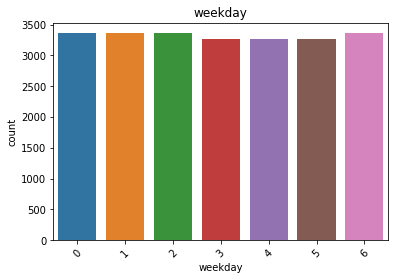

/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


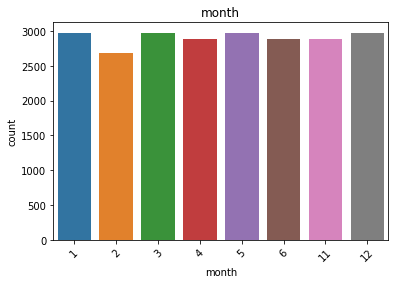

/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


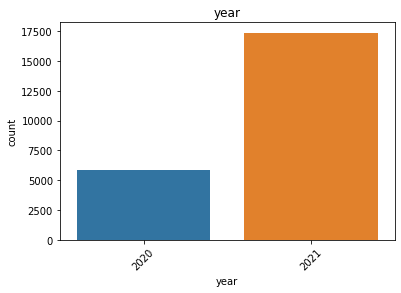

/home/sotiris/opt/inergy/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


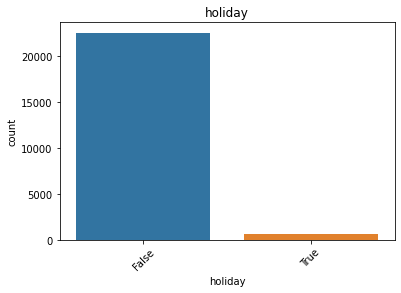

In [12]:
for col in ['weekday','month','year', 'holiday']:
    sns.countplot(calendar[col])
    plt.title(col)
    plt.xticks(rotation=45)
    plt.show()

### Observations from calendar EDA
1. We have data for all the weekdays without equal counts though. Data starts on Saturday (6) and ends on Wednesday (4) so some clarification is essential here.
2. Month data quantity is fluctuating according to fluctuation of days of each month (28, 30. 31)
3. As we have 6 month data from 2021 and 2 from 2020 the year distribution looks OK.
4. Same thing for the 7 holidays in total that are observed in our dataset.

## Smart meter time series EDA